# Augmented Poisson Operator

Objectives:

* Capture the non-zero structure of the augmented Poisson operator (in presence of a immersed boundary)

In [1]:
import math
import numpy
from scipy.sparse import csr_matrix, hstack, identity

import pyibm

from helper import plot_contourf

In [2]:
%matplotlib inline

In [3]:
pyibm.__version__

'0.1'

## Create stretched Cartesian grids

In [4]:
# Set parameters of the computational grid.
xlim, ylim = (-15.0, 35.0), (-25.0, 25.0)  # domain limits
xbox, ybox = (-0.75, 0.75), (-0.75, 0.75)  # uniform region
dx, dy = 1.5 / 90, 1.5 / 90  # grid spacings in the uniform region

config_x = [dict(start=xlim[0], end=xbox[0],
                 width=dx, stretching=1.03, reverse=True),
            dict(start=xbox[0], end=xbox[1], width=dx),
            dict(start=xbox[1], end=xlim[1],
                 width=dx, stretching=1.01)]

config_y = [dict(start=ylim[0], end=ybox[0],
                 width=dy, stretching=1.04, reverse=True),
            dict(start=ybox[0], end=ybox[1], width=dy),
            dict(start=ybox[1], end=ylim[1],
                 width=dy, stretching=1.04)]

config = {'x': dict(start=xlim[0], segments=config_x),
          'y': dict(start=ylim[0], segments=config_y)}

# Create staggered grids.
grid = pyibm.GridBase(config=config)  # vertex grid
gridc = pyibm.GridCellCentered(grid=grid)  # cell-centered grid
gridx = pyibm.GridFaceX(grid=grid)  # x-face centered grid
gridy = pyibm.GridFaceY(grid=grid)  # y-face centered grid
print(gridc)
print(gridx)
print(gridy)

Grid(size=151980, shape=(298, 510), gridlines=[
Gridline(start=-15.0, end=35.0, size=510),
Gridline(start=-25.0, end=25.0, size=298)])
Grid(size=151682, shape=(298, 509), gridlines=[
Gridline(start=-15.0, end=35.0, size=509),
Gridline(start=-25.0, end=25.0, size=298)])
Grid(size=151470, shape=(297, 510), gridlines=[
Gridline(start=-15.0, end=35.0, size=510),
Gridline(start=-25.0, end=25.0, size=297)])


## Assemble operators

In [5]:
# Assemble non-normalized gradient operator.
GHat = pyibm.assemble_GHat(gridc, gridx, gridy)
pyibm.print_matrix_info(GHat, name='GHat')

# Assemble non-normalized divergence operator.
DHat = pyibm.assemble_DHat(gridc, gridx, gridy)
pyibm.print_matrix_info(DHat, name='DHat')

Name:  GHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 151980)
Size:  606304
Min/Max:  -60.134521255196866 60.134521255196866
Name:  DHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (151980, 303152)
Size:  606304
Min/Max:  -0.9487500515261473 0.9487500515261473


In [6]:
# Assemble diagonal scaling operators.
MHat = pyibm.assemble_MHat(gridx, gridy)
R = pyibm.assemble_R(gridx, gridy)
RInv = pyibm.diagonal_inv(R)

# $M = \hat{M} R^{-1}$ (Taira & Colonius, 2007).
M = MHat @ RInv

In [7]:
# Normalize gradient and divergence operators.
# $G = \hat{M} \hat{G}$ (Taira & Colonius, 2007).
G = MHat @ GHat
pyibm.print_matrix_info(G, name='G')
# $D = \hat{D} R^{-1}$ (Taira & Colonius, 2007).
D = DHat @ RInv
pyibm.print_matrix_info(D, name='D')

# Divergence should be the opposite transposed gradient.
K = D + G.T
K = K.multiply(abs(K) > 1e-15) # remove extremely small values
pyibm.print_matrix_info(K, name='D + G^T')

Name:  G
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 151980)
Size:  606304
Min/Max:  -1.0 1.0
Name:  D
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (151980, 303152)
Size:  606304
Min/Max:  -1.0 1.0
Name:  D + G^T
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (151980, 303152)
Size:  0


Indeed, we have $D = -G^T$ with their elements equal to $+1$ or $-1$.

## Assemble delta operator

In [8]:
def circle(radius=0.5, center=(0.0, 0.0), ds=0.1, phi=0.0):
    """Compute uniformly distributed coordinates on circle."""
    xc, yc = center
    N = math.ceil(2 * math.pi * radius / ds)
    theta = numpy.linspace(0.0, 2 * math.pi, num=N + 1)[:-1] + phi
    x = xc + radius * numpy.cos(theta)
    y = yc + radius * numpy.sin(theta)
    return x, y

In [9]:
# Create an immersed boundary.
body = pyibm.Body(*circle(ds=dx), grid=gridc)
body

Body(ndim=2, size=189)

In [10]:
# Set the delta kernel to use and its size.
delta_kernel = pyibm.delta_roma_et_al_1999
delta_kernel_size = 2

In [11]:
# Assemble the delta operator.
Op = pyibm.assemble_delta(body, gridc, gridx, gridy,
                          kernel=delta_kernel,
                          kernel_size=delta_kernel_size)
pyibm.print_matrix_info(Op, name='Delta')

Name:  Delta
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (378, 303152)
Size:  3396
Min/Max:  -1.7758636351745096e-13 1599.977177658422


In [12]:
# Assemble interpolation operator as in Taira & Colonius (2007).
alpha = dx * dy
EHat = alpha * Op
pyibm.print_matrix_info(EHat, name='EHat')

# Assemble normalized interpolation (Taira & Colonius, 2007).
E = EHat @ RInv
pyibm.print_matrix_info(E, name='E')

Name:  EHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (378, 303152)
Size:  3396
Min/Max:  -4.9329545421514156e-17 0.44443810490511726
Name:  E
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (378, 303152)
Size:  3396
Min/Max:  -2.95977272529085e-15 26.66628629430713


In [13]:
# Assemble spreading operator (Taira & Colonius, 2007).
p1, p2 = (body.x[0], body.y[0]), (body.x[1], body.y[1])
ds = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
beta = ds
HHat = beta / alpha * csr_matrix(EHat.T)
pyibm.print_matrix_info(HHat, name='HHat')

# $H = \hat{M} \hat{H}$ (Taira & Colonius, 2007).
H = MHat @ HHat
pyibm.print_matrix_info(H, name='H')

Name:  HHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 378)
Size:  3396
Min/Max:  -2.951737164867962e-15 26.593889331884572
Name:  H
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 378)
Size:  3396
Min/Max:  -4.919561941446602e-17 0.443231488864742


In [14]:
# Check that the velocity is correctly interpolated onto the boundary.
a, b = 2.2, -1.1
ux = a * numpy.ones(gridx.size)
uy = b * numpy.ones(gridy.size)
u = numpy.concatenate((ux, uy))

U = EHat @ u
Ux, Uy = U[::body.ndim], U[1::body.ndim]

assert numpy.all(Ux - a < 1e-12)
assert numpy.all(Uy - b < 1e-12)

In [15]:
# Check total Lagrangian forces is conserved after spreading.
a, b = 2.2, -1.1
Fx = a * numpy.ones(body.size)
Fy = b * numpy.ones(body.size)
F = numpy.empty(body.ndim * body.size)
F[::body.ndim], F[1::body.ndim] = Fx, Fy

f = HHat @ F
fx, fy = f[:gridx.size], f[gridx.size:]

assert abs(numpy.sum(Fx) * beta - numpy.sum(fx) * alpha) < 1e-12
assert abs(numpy.sum(Fy) * beta - numpy.sum(fy) * alpha) < 1e-12

## Assemble LHS operator of velocity system

In [16]:
# Assemble the Laplacian operator.
LHat = pyibm.assemble_LHat(gridx, gridy)
pyibm.print_matrix_info(LHat, name='LHat')

# $L = \hat{M} \hat{L} R^{-1}$ (Taira & Colonius, 2007). 
L = MHat @ LHat @ RInv
pyibm.print_matrix_info(L, name='L')

Name:  LHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 303152)
Size:  1512532
Symmetric:  False
Min/Max:  -14438.64493694621 3624.2863724586446
Name:  L
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 303152)
Size:  1512532
Symmetric:  False
Min/Max:  -406082.701915188 202344.96463084465


In [17]:
# Assemble the implicit operator for the velocity system.
dt = 0.01  # time-step size
I = identity(gridx.size + gridy.size)
Re = 100.0  # Reynolds number
a_I = 0.5  # implicit coefficient of Crank-Nicolson scheme
AHat = 1 / dt * I - a_I / Re * LHat
pyibm.print_matrix_info(AHat, name='AHat')

# $A = \hat{M} \hat{A} R^{-1}$ (Taira & Colonius, 2007).
A = MHat @ AHat @ RInv
pyibm.print_matrix_info(A, name='A (TC2007)')

Name:  AHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 303152)
Size:  1512532
Symmetric:  False
Min/Max:  -18.121431862293225 172.19322468473104
Name:  A (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 303152)
Size:  1512532
Symmetric:  True
Min/Max:  -1011.7248231542231 7638.533449317351


## Assemble Poisson operator

In [18]:
N = 1  # order of Taylor series truncation
dt = 0.01  # time-step size
BN = pyibm.assemble_BN(gridx, gridy, dt=dt, N=N, L=L, M=M)
pyibm.print_matrix_info(BN, name=f'B{N}')
print('Condition number: ', pyibm.condition_number(BN))

Name:  B1
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (303152, 303152)
Size:  303152
Symmetric:  True
Min/Max:  0.01 0.01
Condition number:  (0.009999999999999998, 0.010000000000000004, 1.0000000000000004)


In [19]:
# Assemble QTBNQ as in Taira & Colonius (2007).
Q = hstack([G, E.T])
QTBNQ = Q.T @ BN @ Q
pyibm.print_matrix_info(QTBNQ, name='QTBNQ')
print('Condition number: ', pyibm.condition_number(QTBNQ))

Name:  QTBNQ
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (152358, 152358)
Size:  769464
Symmetric:  True
Min/Max:  -0.2307380108688827 9.000000000000194
Condition number:  (-3.036712303798813e-20, 18.316919904611247, -6.03182589331807e+20)


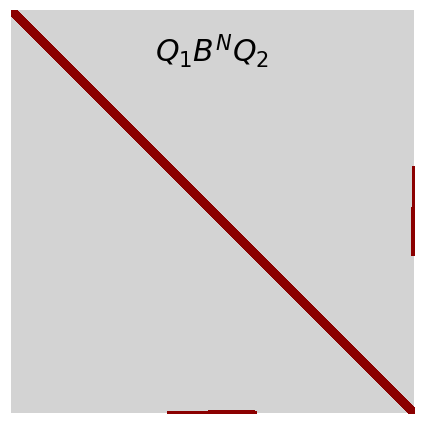

In [20]:
# Plot the non-zero structure of the operator.
fig, ax = pyibm.plot_matrix(QTBNQ, color='darkred', markersize=10)
ax.set_facecolor('lightgray')
for loc in ('left', 'right', 'bottom', 'top'):
    ax.spines[loc].set_visible(False)
ax.text(0.5, 0.9, '$Q_1 B^N Q_2$',
        horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, fontsize=30)
fig.tight_layout()
fig.savefig('modified_poisson_operator.png', dpi=300, bbox_inches='tight')